In [110]:
# Install and import required packages
# Uncomment and run if packages are not installed
# !pip install openml pandas numpy tqdm

import os
import time
import warnings
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import openml
from openml.exceptions import OpenMLServerException

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

In [111]:
# Setup directory structure
def setup_directories(base_dir="openml_data"):
    """Create necessary directories for storing datasets and metadata."""
    dirs = {
        "base": base_dir,
        "datasets": os.path.join(base_dir, "datasets"),
        "metadata": os.path.join(base_dir, "metadata"),
    }
    
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    print(f"Created directories: {', '.join(dirs.values())}")
    return dirs

In [112]:
# Function to get dataset list from OpenML
def get_dataset_list(n_datasets, task_type="all", max_retries=3, random_seed=42):
    """Get a list of OpenML dataset IDs suitable for meta-learning.
    
    Args:
        n_datasets: Number of datasets to retrieve
        task_type: Type of ML task ("all", "classification", or "regression")
        max_retries: Maximum number of retries for API calls
        random_seed: Random seed for reproducibility
        
    Returns:
        List of dataset IDs
    """
    np.random.seed(random_seed)
    
    for attempt in range(max_retries):
        try:
            # Get list of all datasets
            print("Fetching list of datasets from OpenML...")
            datasets = openml.datasets.list_datasets(output_format="dataframe")
            print(f"Found {len(datasets)} datasets on OpenML")
            
            # Apply filters based on task type and dataset characteristics
            if task_type == "classification":
                filtered_datasets = datasets[
                    (datasets['NumberOfInstances'] >= 100) & 
                    (datasets['NumberOfInstances'] <= 100000) &
                    (datasets['NumberOfFeatures'] >= 5) &
                    (datasets['NumberOfFeatures'] <= 1000) &
                    (datasets['NumberOfClasses'] > 1)  # Classification datasets only
                ]
            elif task_type == "regression":
                filtered_datasets = datasets[
                    (datasets['NumberOfInstances'] >= 100) & 
                    (datasets['NumberOfInstances'] <= 100000) &
                    (datasets['NumberOfFeatures'] >= 5) &
                    (datasets['NumberOfFeatures'] <= 1000) &
                    (datasets['NumberOfClasses'].isna())  # Regression datasets don't have classes
                ]
            else:  # All tasks
                filtered_datasets = datasets[
                    (datasets['NumberOfInstances'] >= 100) & 
                    (datasets['NumberOfInstances'] <= 100000) &
                    (datasets['NumberOfFeatures'] >= 5) &
                    (datasets['NumberOfFeatures'] <= 1000)
                ]
            
            print(f"After filtering, {len(filtered_datasets)} datasets remain for {task_type} tasks")
            
            if len(filtered_datasets) < n_datasets:
                print(f"Warning: Requested {n_datasets} datasets but only {len(filtered_datasets)} meet criteria. Using all available.")
                dataset_ids = filtered_datasets.index.tolist()
            else:
                # Sample random datasets
                dataset_ids = np.random.choice(
                    filtered_datasets.index, 
                    size=n_datasets, 
                    replace=False
                ).tolist()
            
            return dataset_ids
            
        except OpenMLServerException as e:
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"API error: {e}. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"Failed to get dataset list after {max_retries} attempts: {e}")
                raise
    
    return []

In [113]:
# Function to process a single dataset
def process_dataset(dataset_id, dirs):
    """Process a single dataset: download and extract metadata and meta-features.
    
    Args:
        dataset_id: OpenML dataset ID
        dirs: Dictionary of directory paths
        
    Returns:
        Dictionary containing metadata and meta-features or error information
    """
    dataset_file = os.path.join(dirs["datasets"], f"dataset_{dataset_id}.csv")
    
    try:
        # Get dataset information
        dataset = openml.datasets.get_dataset(dataset_id)
        
        # Create a dictionary for the essential metadata
        metadata = {
            'dataset_id': dataset_id,
            'name': dataset.name,
            'num_instances': dataset.qualities.get('NumberOfInstances'),
            'num_features': dataset.qualities.get('NumberOfFeatures'),
            'num_classes': dataset.qualities.get('NumberOfClasses'),
            'num_missing_values': dataset.qualities.get('NumberOfMissingValues'),
            'has_missing_values': dataset.qualities.get('NumberOfMissingValues', 0) > 0,
            'default_target': dataset.default_target_attribute
        }
        
        # Extract all meta-features (qualities)
        meta_features = dataset.qualities
        
        # Save dataset locally only if it doesn't exist yet
        if not os.path.exists(dataset_file):
            try:
                X, y, categorical_indicator, attribute_names = dataset.get_data(
                    dataset_format="dataframe", target=dataset.default_target_attribute
                )
                
                # Create a combined dataframe and save it
                data = X.copy()
                if y is not None and dataset.default_target_attribute:
                    data[dataset.default_target_attribute] = y
                
                # Save pandas DataFrame to CSV instead of pickle
                data.to_csv(dataset_file, index=False)
            except Exception as e:
                print(f"Warning: Could not download dataset {dataset_id}: {e}")
                # We still continue since we already have the metadata and meta-features
        
        # Combine metadata and meta-features and return
        return {**metadata, **meta_features}
        
    except Exception as e:
        print(f"Error processing dataset {dataset_id}: {e}")
        return {'dataset_id': dataset_id, 'error': str(e)}

In [114]:
# Function to extract metadata and meta-features sequentially
def extract_metadata_and_features(dataset_ids, dirs):
    """Extract metadata and meta-features from datasets one by one.
    
    Args:
        dataset_ids: List of dataset IDs
        dirs: Dictionary of directory paths
        
    Returns:
        DataFrame with metadata and meta-features
    """
    results = []
    successful_ids = []
    failed_ids = []
    
    # Check if we already have results saved
    cache_file = os.path.join(dirs["metadata"], "dataset_cache.csv")
    if os.path.exists(cache_file):
        cached_data = pd.read_csv(cache_file)
        print(f"Found cached metadata for {len(cached_data)} datasets")
        
        # Filter out datasets we already have
        cached_ids = cached_data['dataset_id'].tolist()
        new_dataset_ids = [id for id in dataset_ids if id not in cached_ids]
        
        if not new_dataset_ids:
            print("All requested datasets already in cache. Using cached data.")
            return cached_data
        
        print(f"Need to process {len(new_dataset_ids)} new datasets")
        dataset_ids = new_dataset_ids
        results = cached_data.to_dict('records')
    
    print(f"Processing {len(dataset_ids)} datasets sequentially...")
    
    # Process datasets one by one
    for dataset_id in tqdm(dataset_ids):
        try:
            metadata = process_dataset(dataset_id, dirs)
            results.append(metadata)
            if 'error' not in metadata:
                successful_ids.append(dataset_id)
            else:
                failed_ids.append(dataset_id)
        except Exception as e:
            print(f"Exception occurred while processing dataset {dataset_id}: {e}")
            failed_ids.append(dataset_id)
            results.append({'dataset_id': dataset_id, 'error': str(e)})
    
    print(f"Successfully processed {len(successful_ids)} datasets")
    if failed_ids:
        print(f"Failed to process {len(failed_ids)} datasets: {failed_ids}")
    
    # Convert to DataFrame and save to cache
    metadata_df = pd.DataFrame(results)
    metadata_df.to_csv(cache_file, index=False)
    print(f"Updated cache with {len(metadata_df)} datasets")
    
    return metadata_df

In [115]:
# Configure and execute extraction
# Set parameters
n_datasets = 10  # Number of datasets to download
task_type = "all"  # "all", "classification", or "regression"
output_dir = "openml_data"  # Directory to store datasets and metadata

# Set the random seed directly before getting dataset list
import numpy as np
np.random.seed(31)

# Execute extraction
dirs = setup_directories(output_dir)
dataset_ids = get_dataset_list(n_datasets, task_type, random_seed=123)
metadata_df = extract_metadata_and_features(dataset_ids, dirs)

Created directories: openml_data, openml_data/datasets, openml_data/metadata
Fetching list of datasets from OpenML...
Found 6039 datasets on OpenML
After filtering, 3315 datasets remain for all tasks
Processing 10 datasets sequentially...


  0%|          | 0/10 [00:00<?, ?it/s]

Successfully processed 10 datasets
Updated cache with 10 datasets


In [116]:
# Analyze the extracted metadata and meta-features
# Check the shape and preview the data
print(f"Shape of the metadata DataFrame: {metadata_df.shape}")
metadata_df.head()

Shape of the metadata DataFrame: (10, 115)


,dataset_id,name,num_instances,num_features,num_classes,num_missing_values,has_missing_values,default_target,AutoCorrelation,Dimensionality,...,RandomTreeDepth1Kappa,RandomTreeDepth2AUC,RandomTreeDepth2ErrRate,RandomTreeDepth2Kappa,RandomTreeDepth3AUC,RandomTreeDepth3ErrRate,RandomTreeDepth3Kappa,kNN1NAUC,kNN1NErrRate,kNN1NKappa
0,44032,fifa,18063.0,6.0,0.0,0.0,False,wage_eur,0.250355,0.000332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40650,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,1600.0,21.0,2.0,0.0,False,class,0.999375,0.013125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,46138,Cancer_Drug_Response_expression,475.0,698.0,0.0,0.0,False,Methotrexate_GDSC_1008,-0.915788,1.469474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44127,phoneme,3172.0,6.0,2.0,0.0,False,Class,0.999685,0.001892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41548,scene,2407.0,300.0,NaN,0.0,False,"Beach,Sunset,FallFoliage,Field,Mountain,Urban",NaN,0.124636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
# Filter out datasets with errors and examine meta-features
# Remove rows with errors
if 'error' in metadata_df.columns:
    clean_df = metadata_df[metadata_df.error.isna()].drop(columns=['error'])
else:
    clean_df = metadata_df.copy()

# Get essential metadata columns
metadata_cols = ['dataset_id', 'name', 'num_instances', 'num_features', 
                'num_classes', 'num_missing_values', 'has_missing_values',
                'default_target']

# List all available meta-features
meta_feature_cols = [col for col in clean_df.columns 
                    if col not in metadata_cols and 
                    not col.startswith('_')]

print(f"Number of meta-features: {len(meta_feature_cols)}")
print("\nSample meta-features:")
print(meta_feature_cols[:20])

Number of meta-features: 107

Sample meta-features:
['AutoCorrelation', 'Dimensionality', 'MajorityClassPercentage', 'MajorityClassSize', 'MinorityClassPercentage', 'MinorityClassSize', 'NumberOfBinaryFeatures', 'NumberOfClasses', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfInstancesWithMissingValues', 'NumberOfMissingValues', 'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 'PercentageOfBinaryFeatures', 'PercentageOfInstancesWithMissingValues', 'PercentageOfMissingValues', 'PercentageOfNumericFeatures', 'PercentageOfSymbolicFeatures', 'ClassEntropy']


In [118]:
# Check for missing values in meta-features
# Count missing values per meta-feature
missing_values = clean_df[meta_feature_cols].isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print(f"Meta-features with missing values: {len(missing_values)}")
if len(missing_values) > 0:
    print("\nTop 10 meta-features with most missing values:")
    print(missing_values.head(10))

Meta-features with missing values: 94

Top 10 meta-features with most missing values:
kNN1NKappa           9
NaiveBayesAUC        9
J48.001.ErrRate      9
J48.001.AUC          9
J48.0001.Kappa       9
J48.0001.ErrRate     9
J48.0001.AUC         9
J48.00001.Kappa      9
J48.00001.ErrRate    9
J48.00001.AUC        9
dtype: int64


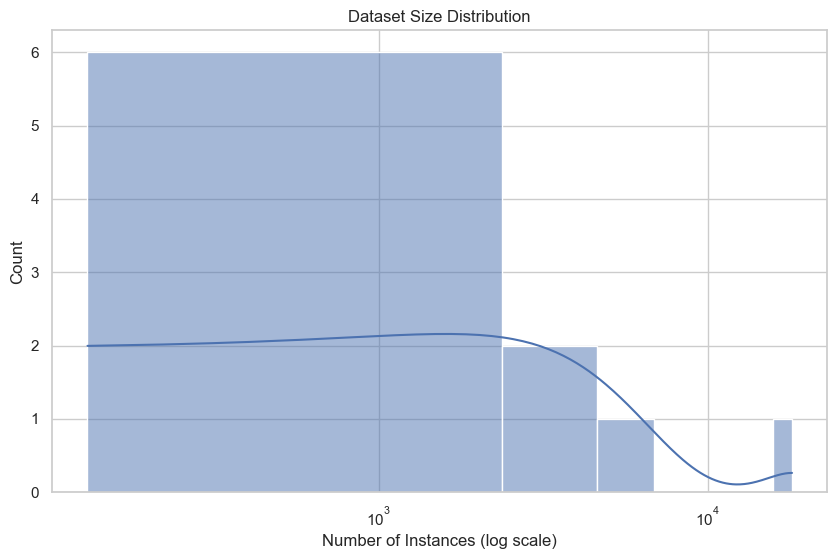

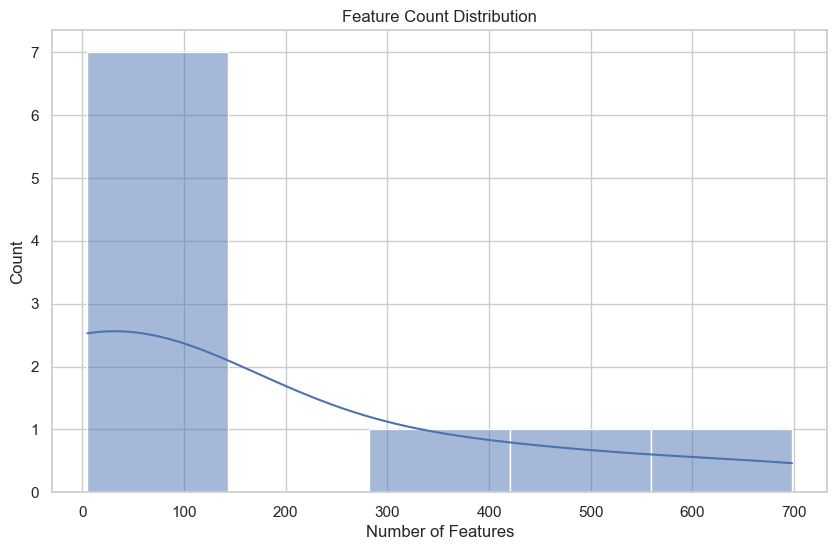

In [119]:
# Visualize dataset properties
# Uncomment the following code to visualize dataset properties

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
sns.set(style="whitegrid")

# Dataset size distribution
plt.figure(figsize=(10, 6))
plt.title("Dataset Size Distribution")
sns.histplot(clean_df['num_instances'].dropna(), kde=True)
plt.xscale('log')
plt.xlabel('Number of Instances (log scale)')
plt.ylabel('Count')
plt.show()

# Feature count distribution
plt.figure(figsize=(10, 6))
plt.title("Feature Count Distribution")
sns.histplot(clean_df['num_features'].dropna(), kde=True)
plt.xlabel('Number of Features')
plt.ylabel('Count')
plt.show()

# Class distribution (for classification datasets)
if task_type == "classification":
    plt.figure(figsize=(10, 6))
    plt.title("Class Count Distribution")
    sns.countplot(x=clean_df['num_classes'].dropna())
    plt.xlabel('Number of Classes')
    plt.ylabel('Count')
    plt.show()
